# ETSpy Demo

This notebook demonstrates the basic use and functionality of the ETSpy package.

It covers:
* Loading simulated data
* Basic plotting of tilt series data
* Reconstruction of single slices of simulated data
* Reconstruction of the full simluated dataset
* Saving reconstructed data

If you are viewing this demo on the ETSpy documentation website, it will not be interactive. We recommend downloading the latest version of the demo from [Github](https://github.com/usnistgov/etspy/tree/master/docs/examples/etspy_demo.ipynb) and running it on your local machine.

## Imports
For interactive plotting, we set the Matplotlib backend to `widget`.

In addition to the `etspy` package itself we also need to import:
* `pyplot` from `matplotlib`
* `hyperspy`

Finally, we also need to import the `datasets` module of `etspy` in order to load the simluated data we will be working with.


In [1]:
# %matplotlib inline

## Set to "ipympl" for interactive plots
%matplotlib ipympl

import matplotlib.pyplot as plt
import hyperspy.api as hs

import etspy.api as tomo
from etspy import datasets as ds

## Simulated Catalyst Tilt Series

### Load Data
* Read simulated catalyst tilt series as a TomoStack object
* Each image is shifted randomly to simulate specimen motion during tilt series acquisition

In [2]:
stack = ds.get_catalyst_data(misalign=True)

Metadata about the tilt series is contained in the `Tomography` node:

In [3]:
stack.metadata.Tomography

├── cropped = False
├── tiltaxis = np.int64(0)
├── xshift = np.int64(0)
└── yshift = np.int64(0)

Information about the shifts and the tilts for each projection in the series are contained in the `shifts` and `tilts` attributes as HyperSpy signal objects, respectively:

In [4]:
stack.tilts

<TomoTilts, title: Image tilt values, dimensions: (90|1)>

In [5]:
stack.tilts.axes_manager

<Axes manager, axes: (90|1)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
     Projections |     90 |      0 |       0 |       2 | degrees 
---------------- | ------ | ------ | ------- | ------- | ------ 
     Tilt values |      1 |      0 |       0 |       1 | degrees

In [6]:
stack.shifts

<TomoShifts, title: Image shift values, dimensions: (90|2)>

In [7]:
# show the shifts of the first five projections (in Y/X order):
stack.shifts.data[:5, :]

array([[ 1.86691788, -2.04296474],
       [-3.15441192,  1.07124838],
       [ 2.32879191, -0.49159244],
       [ 2.97467891,  1.15467813],
       [ 0.39544994,  0.19360526]])

### Rebin the data
* To speed things up, we can rebin the dataset by a factor of 2 in the X and Y dimensions
* Uses the underlying Hyperspy rebin method which all TomoStack's inherit from their parent `Signal2D` class

In [8]:
rebin = stack.rebin(scale=[1, 2, 2])
rebin

<TomoStack, title: , dimensions: (90|300, 300)>

### Browse the Rebinned Data
* Uses Hyperspy's plotting functionality
* Plot and view the full series interactively
* Plot a max image of the dataset which emphasizes the misalignment of the stack

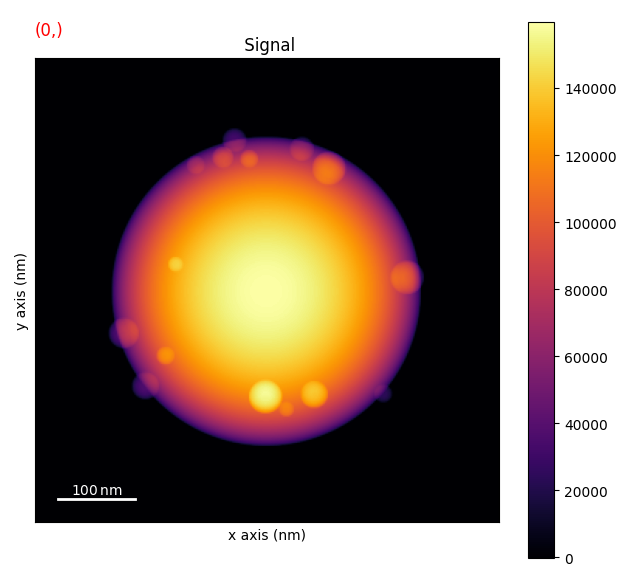

In [9]:
rebin.plot(cmap='inferno')

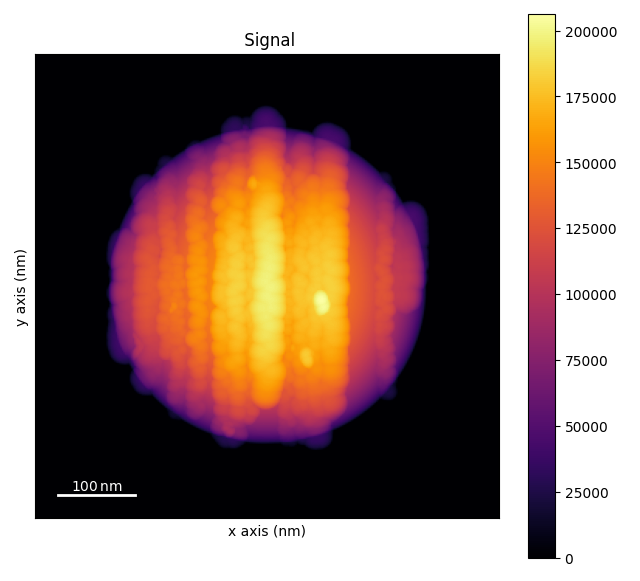

In [10]:
rebin.max().plot(cmap='inferno')

### Stack Registration
* Five methods available:
    * Phase correlation (OpenCV)
    * Enhanced correlation coefficient (OpenCV)
    * StackReg (pystackreg)
    * Center of Mass (T. Sanders et al. doi:10.13140/RG.2.2.33492.60801)
    * Combined Center of Mass and Common-Line Method (UCLA, Scott et al. doi:10.1038/nature10934)

In [11]:
reg = rebin.stack_register('StackReg')

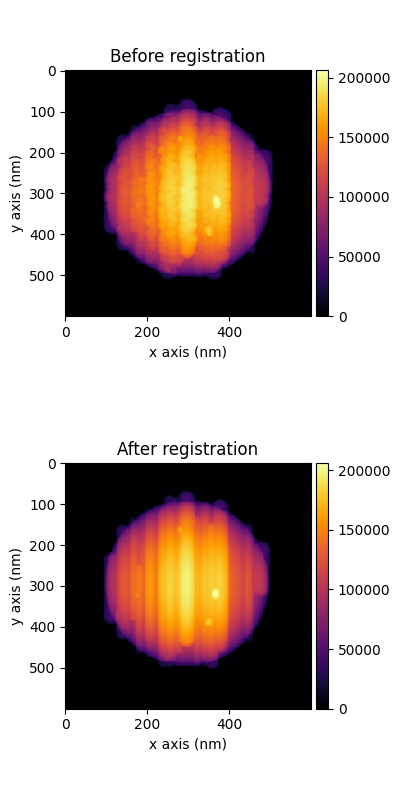

In [12]:
# compare the non-registered and registered max-pixel images:
hs.plot.plot_images(
    [rebin.max(), reg.max()],
    per_row=1,
    label=["Before registration", "After registration"],
    cmap='inferno'
)
plt.gcf().set_size_inches((4,8))
plt.tight_layout()

### Reconstruction

#### Plot single image alongside the sinogram of the central slice

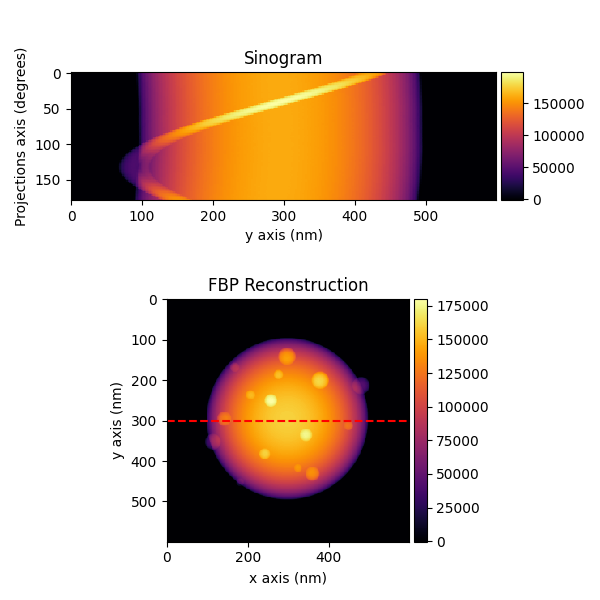

In [13]:
sino = reg.isig[150,:].as_signal2D((1,0))

ax = hs.plot.plot_images([sino, reg.inav[45]], cmap='inferno', per_row=1, label=['Sinogram','FBP Reconstruction'])
ax[1].axhline(300, linestyle='--', color='red')
plt.gcf().set_size_inches((6,6))
plt.tight_layout()

#### Filtered Backprojection of Single Slice (CPU)

In [14]:
recFBP = reg.isig[150:151, :].reconstruct('FBP', cuda=False)

[########################################] | 100% Completed | 203.39 ms


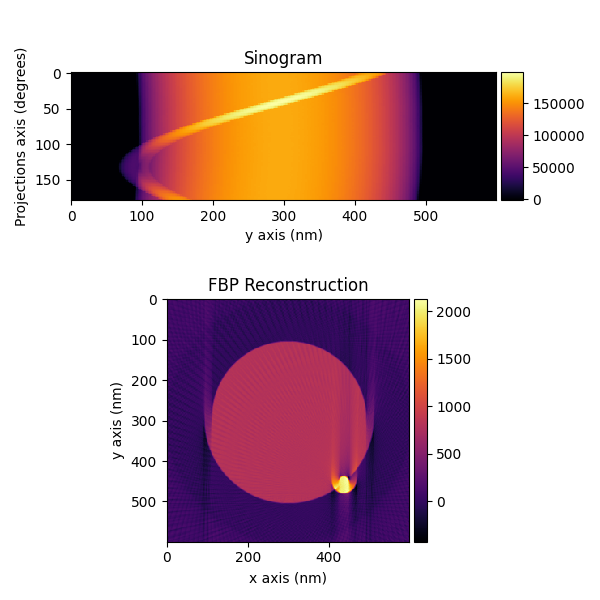

In [15]:
ax = hs.plot.plot_images([sino, recFBP], cmap='inferno', per_row=1, label=['Sinogram','FBP Reconstruction'])
plt.gcf().set_size_inches((6,6))
plt.tight_layout()

#### SIRT Error Analysis
* Perform a SIRT reconstruction and calculate the L2-norm between the forward-projection of each result and the input sinogram
* The reconstruction result is also saved at each iteration for viewing
* Note: Currently, the error output differs between CUDA- and CPU-based reconstructions.  Cause is unknown.

In [16]:
SIRTStack, SIRTerror = reg.isig[150:151, :].recon_error(iterations = 500)
SIRTStack.axes_manager[2].name = 'z'

100%|█████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 668.34it/s]


In [17]:
SIRTStack.plot(navigator=SIRTerror, cmap='inferno')

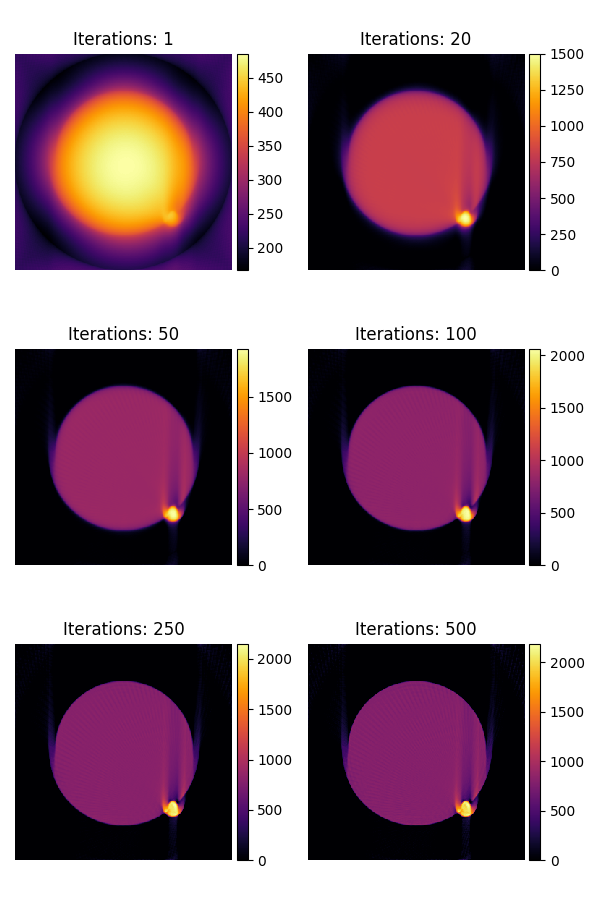

In [18]:
ax = hs.plot.plot_images([SIRTStack.inav[0],SIRTStack.inav[19],SIRTStack.inav[49],
                         SIRTStack.inav[99], SIRTStack.inav[249], SIRTStack.inav[499]],
                         cmap='inferno', per_row=2,
                         axes_decor='off',
                         label=['Iterations: 1','Iterations: 20','Iterations: 50',
                                'Iterations: 100','Iterations: 250','Iterations: 500'])
plt.gcf().set_size_inches(6,9)
plt.tight_layout()

#### Reconstruct the entire binned stack
* Takes less than 30 seconds if using GPU-acceleration

In [19]:
recFBP = reg.reconstruct('FBP', cuda=True)
recSIRT = reg.reconstruct('SIRT', iterations=100, constrain=True, cuda=True)

100%|██████████████████████████████████████████████████████████████████| 300/300 [00:18<00:00, 16.27it/s]


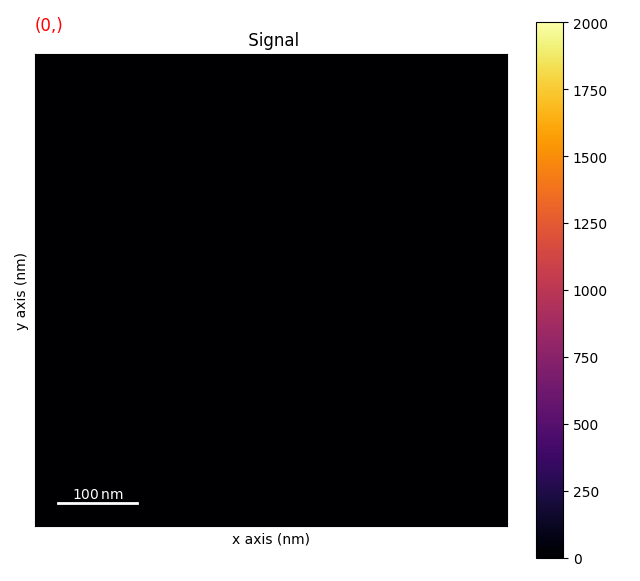

In [20]:
recFBP.plot(vmax=2000, cmap='inferno')

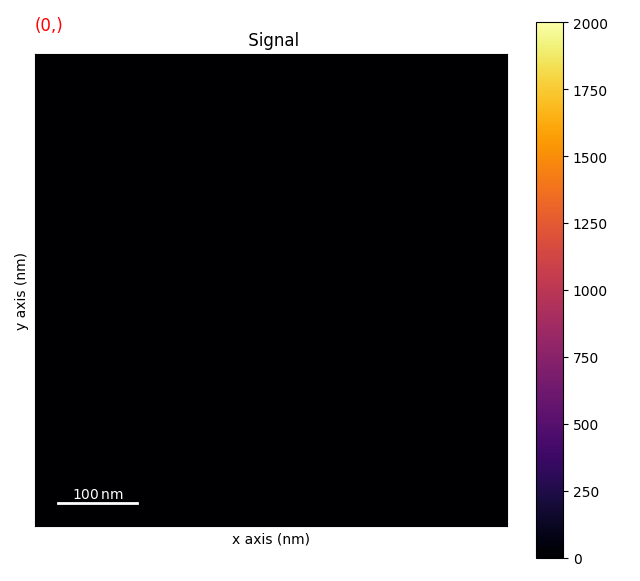

In [21]:
recSIRT.plot(vmax=2000, cmap='inferno')

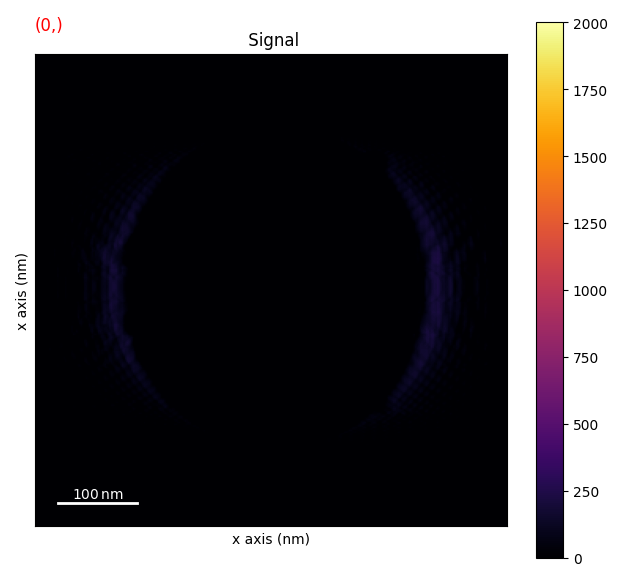

In [22]:
recSIRT.swap_axes(0,2).plot(vmax=2000, cmap='inferno')

#### Save the Reconstruction Results
* Hyperspy-compatible HDF5 is the output format

In [23]:
recFBP.save('FBP_Reconstruction.hdf5', overwrite=True, file_format='HSPY')
recSIRT.save('SIRT_Reconstruction_100.hdf5', overwrite=True, file_format='HSPY')

## Experimental Needle-shaped Sample Tilt Series
* FIB-milled specimen from NIST SRM-2135c
    * Ni/Cr mutli-layer thin film on silicon substrate

In [24]:
stack = ds.get_needle_data()

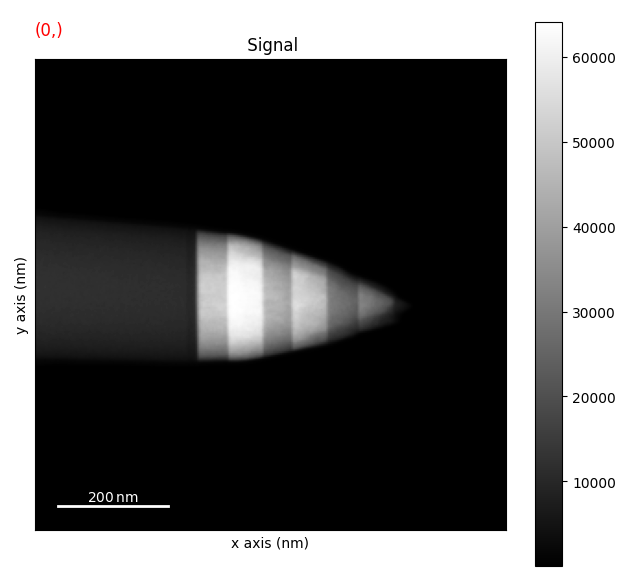

In [25]:
stack.plot(navigator='slider')

### Stack Registration
* Five methods available:
    * Phase correlation (OpenCV)
    * Enhanced correlation coefficient (OpenCV)
    * StackReg (pystackreg)
    * Center of Mass (T. Sanders et al. doi:10.13140/RG.2.2.33492.60801)
    * Combined Center of Mass and Common-Line Method (UCLA, Scott et al. doi:10.1038/nature10934)

In [26]:
reg = stack.stack_register('StackReg')

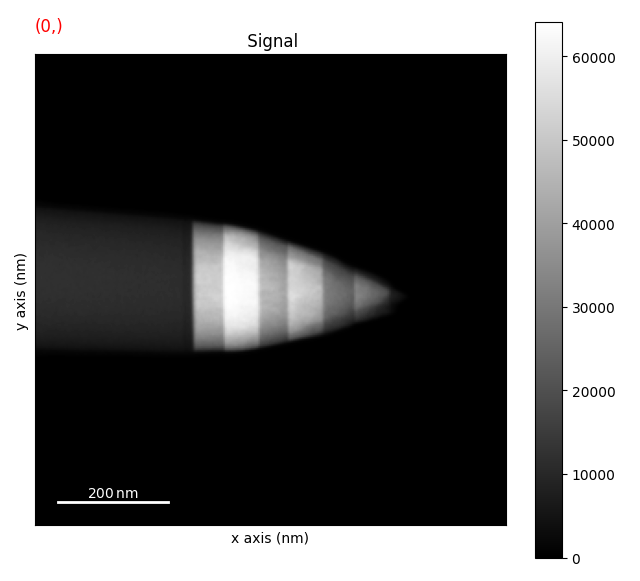

In [27]:
reg.plot(navigator='slider')

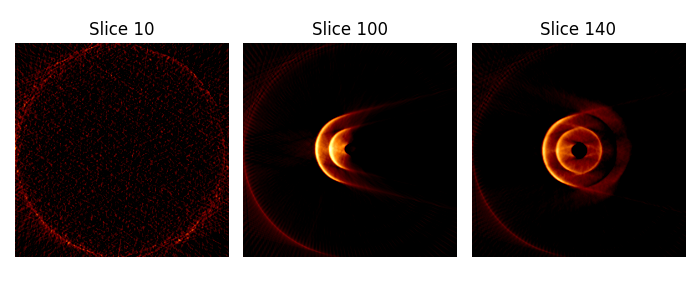

In [28]:
swapped = reg.swap_axes(1,2)
f = swapped.test_align(slices=[10,100,140])

### Tilt Axis Alignment
* Uses the center of mass method (CoM)
* Motion of specimen is fit to that expected for an ideal cylinder
* Fit is performed for three different sinograms 
* The result is used to estimate the tilt axis shift and rotation

In [29]:
ali = reg.tilt_align('CoM')

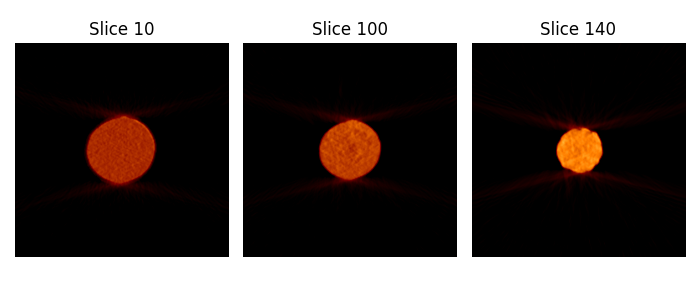

In [31]:
f = ali.test_align(slices=[10,100,140])

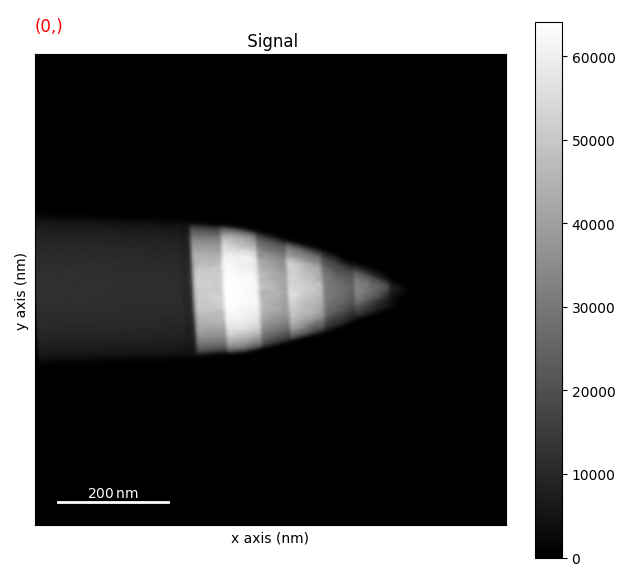

In [32]:
ali.plot()

### Reconstruction

In [33]:
rec = ali.reconstruct('SIRT', 500, constrain=True)

100%|██████████████████████████████████████████████████████████████████| 256/256 [01:00<00:00,  4.20it/s]


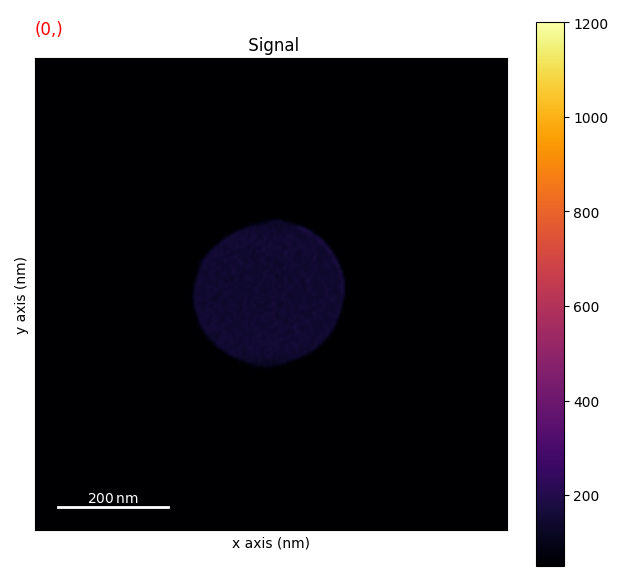

In [34]:
rec.inav[10:205].plot(cmap='inferno', vmin=50, vmax=1200)

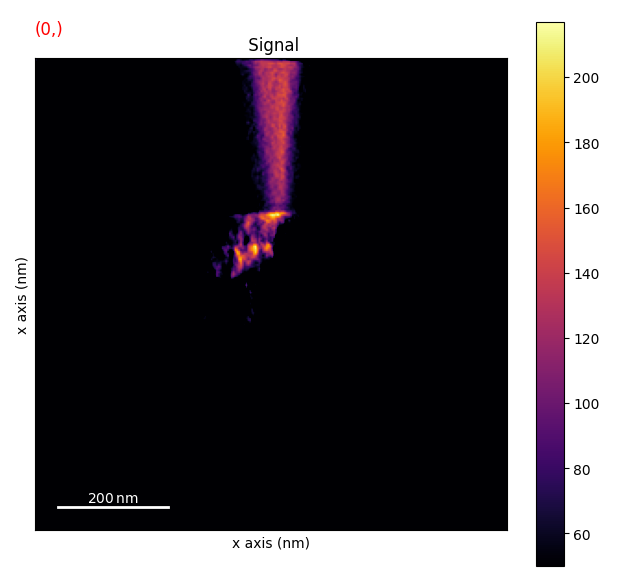

In [35]:
rec.isig[:,90:165].swap_axes(2,0).plot(cmap='inferno', vmin=50)